# Poisson Equation
We consider the two dimensional Poisson equation for two PINNs as in https://arxiv.org/pdf/2109.09444.pdf.
$$
\begin{cases}
    u_{xx} + u_{yy} = f \text{ for } (x,y)\in [0,1]\times [0,1] \\
    u(0, y) = u(1, y) = u(x, 0) = u(x, 1)= 0 \\
\end{cases}
$$

In this case, we consider:
$$
\begin{cases}
    f = 1 \text{ for }(x,y)\in [0.25,0.75] \times [0.25,0.75]\\
    f = 0 \text{    else}
\end{cases}
$$

In [1]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp

from jax import config
import json

config.update("jax_enable_x64", True)

## Initializing the PINN

In [2]:
from utils import data_path, fig_path

file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
activation = np.tanh
xpinn = XPINN(file, activation)

In [3]:
with open(file, "r") as infile:
    data = json.load(infile)

for i, item in enumerate(data["XPINNs"]):
    interior = np.asarray(item["Internal points"])
    boundary = np.asarray(item["Boundary points"])

for item in data["Interfaces"]:
    indices = item["XPINNs"]
    points = np.asarray(item["Points"])
    print(len(points))



80


We visualize the points of the domain decomposition.

(691, 2)
(120, 2)
(209, 2)
(80, 2)


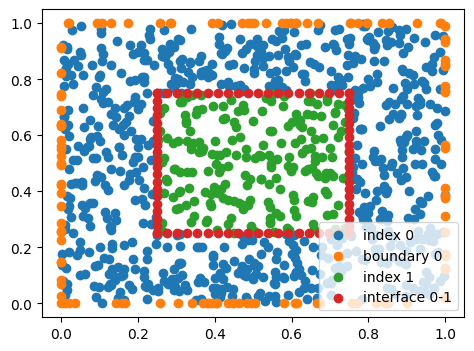

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    print(pinn.interior.shape)
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if pinn.boundary.size != 0:
        print(pinn.boundary.shape)
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    print(p.shape)
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()
#plt.savefig(fig_path / f"Poisson/xpinn_decomp.pdf")

### PINN Formalization
We only consider boundary loss for the outer PINN.

### Setting the loss function
We create a base function for initializing the boundary loss functions, which is relatively simple in this case. 

In [5]:
from typing import Callable
from type_util import Params
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))


def boundary_loss_factory(target: float | Array) -> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss


In [6]:
def interior_loss_factory(index: int, rhs: Callable[[Array], Array]) -> LFunc:
            
    def hess(params):
        return hessian(lambda x: model(params, x))

    def residual(params, x):
        return np.trace(hess(params)(x)[0]) + rhs(x)

    v_residual = jit(vmap(residual, (None, 0)))#vmap(residual, (None, 0))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts) ** 2)

    return interior_loss

In [7]:
@jit
def u_star(x):
    return np.prod(np.sin(np.pi * x))

# rhs
@jit
def f(x):
    return 2. * np.pi**2 * u_star(x)

f_v = f
f_final = jit(f_v)

Setting the boundary and interior loss

In [8]:
p0, p1 = xpinn.PINNs

p0.boundary_loss = boundary_loss_factory(0.0)

p0.interior_loss = interior_loss_factory(0, f)  # implementing rhs
p1.interior_loss = interior_loss_factory(1, f)

Setting the interface loss

In [9]:
def interface_loss_factory(i: int, j: int) -> LFunc:
    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return 80 * (res_ij + avg_ij)

    return interface_loss

In [10]:
p0.interface_loss = interface_loss_factory(0, 1)
p1.interface_loss = interface_loss_factory(1, 0)

In [11]:
shapes = [[2] + [64] + [1],[2] + [64] + [64] + [1]]
exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
optimizer = optax.adam(learning_rate=exponential_decay)
xpinn.initialize_params(shapes, optimizer)

In [12]:
#n_iter = 200#200000
xpinn.set_loss()
#losses = xpinn.run_iters(n_iter)

In [13]:
#a_losses = losses
#t_0 = 0
#t_end = min(20000, n_iter)
#t = np.arange(t_0, t_end)
#
#for i in range(2):
#    plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
#plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
#plt.xlabel("epoch")
#plt.ylabel("loss")
#plt.yscale("log")
#plt.legend()
#plt.title(f"Loss per Pinn over {n_iter} epochs")

In [14]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)
min_, max_ = total_pred.min(), total_pred.max()
min_, max_ = 0, 1

[[0.14285715 0.14285715]
 [0.2857143  0.14285715]
 [0.42857146 0.14285715]
 [0.5714286  0.14285715]
 [0.71428573 0.14285715]
 [0.85714293 0.14285715]
 [0.14285715 0.2857143 ]
 [0.85714293 0.2857143 ]
 [0.14285715 0.42857146]
 [0.85714293 0.42857146]
 [0.14285715 0.5714286 ]
 [0.85714293 0.5714286 ]
 [0.14285715 0.71428573]
 [0.85714293 0.71428573]
 [0.14285715 0.85714293]
 [0.2857143  0.85714293]
 [0.42857146 0.85714293]
 [0.5714286  0.85714293]
 [0.71428573 0.85714293]
 [0.85714293 0.85714293]]
hi
[[0.2857143  0.2857143 ]
 [0.42857146 0.2857143 ]
 [0.5714286  0.2857143 ]
 [0.71428573 0.2857143 ]
 [0.2857143  0.42857146]
 [0.42857146 0.42857146]
 [0.5714286  0.42857146]
 [0.71428573 0.42857146]
 [0.2857143  0.5714286 ]
 [0.42857146 0.5714286 ]
 [0.5714286  0.5714286 ]
 [0.71428573 0.5714286 ]
 [0.2857143  0.71428573]
 [0.42857146 0.71428573]
 [0.5714286  0.71428573]
 [0.71428573 0.71428573]]
hi


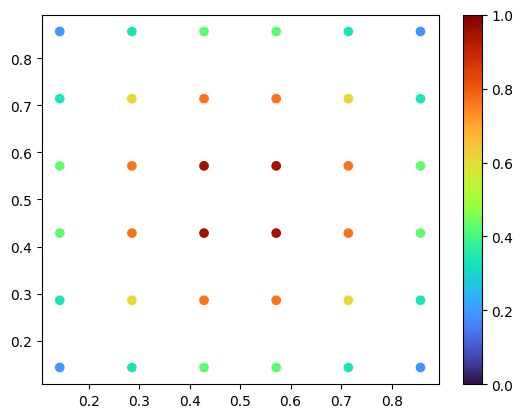

In [15]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=np.sin(np.pi * point[:, 0]) * np.sin(np.pi * point[:, 1]), cmap="turbo")
    
    plt.clim(min_, max_)
plt.colorbar()

In [16]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)

#print(total_points)
min_, max_ = total_pred.min(), total_pred.max()
true_value = np.sin(np.pi * total_points[:, 0]) * np.sin(np.pi * total_points[:, 1])
# true_value
true_value = true_value.reshape(total_pred.shape)

[[0.14285715 0.14285715]
 [0.2857143  0.14285715]
 [0.42857146 0.14285715]
 [0.5714286  0.14285715]
 [0.71428573 0.14285715]
 [0.85714293 0.14285715]
 [0.14285715 0.2857143 ]
 [0.85714293 0.2857143 ]
 [0.14285715 0.42857146]
 [0.85714293 0.42857146]
 [0.14285715 0.5714286 ]
 [0.85714293 0.5714286 ]
 [0.14285715 0.71428573]
 [0.85714293 0.71428573]
 [0.14285715 0.85714293]
 [0.2857143  0.85714293]
 [0.42857146 0.85714293]
 [0.5714286  0.85714293]
 [0.71428573 0.85714293]
 [0.85714293 0.85714293]]
hi
[[0.2857143  0.2857143 ]
 [0.42857146 0.2857143 ]
 [0.5714286  0.2857143 ]
 [0.71428573 0.2857143 ]
 [0.2857143  0.42857146]
 [0.42857146 0.42857146]
 [0.5714286  0.42857146]
 [0.71428573 0.42857146]
 [0.2857143  0.5714286 ]
 [0.42857146 0.5714286 ]
 [0.5714286  0.5714286 ]
 [0.71428573 0.5714286 ]
 [0.2857143  0.71428573]
 [0.42857146 0.71428573]
 [0.5714286  0.71428573]
 [0.71428573 0.71428573]]
hi


In [61]:
sorted_points= np.array(sorted(total_points, key = lambda p: (p[1],p[0])))
true_value = np.sin(np.pi * sorted_points[:, 0]) * np.sin(np.pi * sorted_points[:, 1])
n = int(np.sqrt(sorted_points.shape[0]))
X = sorted_points[:, 0]
Y = sorted_points[:, 1]

X = X.reshape(n, n)
Y = Y.reshape(n, n)
true_value= true_value.reshape(n,n)


positions = np.dstack((X,Y))
inner = onp.trapz(true_value**2, positions[:])
#print(positions.shape)
#print(true_value)
print(positions[:,:,0])
print(positions[:,0,1])
inner = onp.trapz(onp.trapz((true_value)**2, positions[:,:,0], axis=1), positions[:,0,1],axis=0)
print(inner)
#for i in range(n):
#    print()
#print(positions[:, 0,:])
#print(onp.trapz((true_value)**2, sorted_points[0:n,0], axis=0))

#print(true_value)
#print()

[[0.14285715 0.2857143  0.42857146 0.5714286  0.71428573 0.85714293]
 [0.14285715 0.2857143  0.42857146 0.5714286  0.71428573 0.85714293]
 [0.14285715 0.2857143  0.42857146 0.5714286  0.71428573 0.85714293]
 [0.14285715 0.2857143  0.42857146 0.5714286  0.71428573 0.85714293]
 [0.14285715 0.2857143  0.42857146 0.5714286  0.71428573 0.85714293]
 [0.14285715 0.2857143  0.42857146 0.5714286  0.71428573 0.85714293]]
[0.14285715 0.2857143  0.42857146 0.5714286  0.71428573 0.85714293]
0.2238296924418254


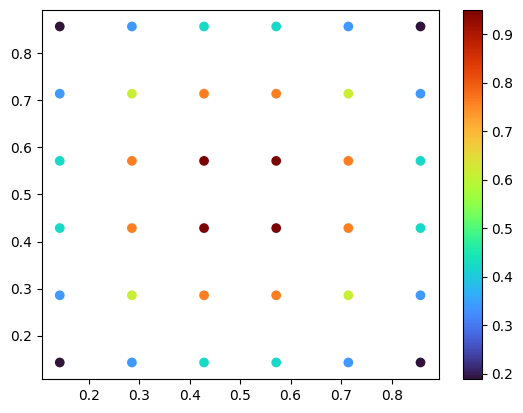

In [18]:
plt.scatter(total_points[:, 0], total_points[:, 1], c=np.sin(np.pi * total_points[:, 0]) * np.sin(np.pi * total_points[:, 1]), cmap="turbo")
plt.colorbar()

In [19]:
### L2 normalization 
# Values in x to evaluate the integral.
n = int(np.sqrt(total_points.shape[0]))
X = total_points[:, 0]
Y = total_points[:, 1]

X = X.reshape(n, n)
Y = Y.reshape(n, n)

total_pred=total_pred.reshape(n,n)
true_value= true_value.reshape(n,n)

inner = onp.trapz((total_pred-true_value)**2, total_points[0:n,0], axis=0)
outer = onp.trapz(inner, total_points[::n,1], axis=0)
l2_err = np.sqrt(outer)
normalizer = np.sqrt(onp.trapz(onp.trapz((true_value)**2, total_points[0:n,0], axis=0),total_points[::n,1], axis=0))
print(l2_err/normalizer)
print(normalizer)

0.5351432423080539
0.3439136969349687


In [20]:
### Rel L2 norms 900 interior, 120 boundary, 80 interface
#0.14870665096447913
import scipy as sp


In [21]:
def true_star(x,y):
    return onp.sin(np.pi * x)*onp.sin(np.pi * x)

print(sp.integrate.dblquad(true_star,0,1,0,1))

(0.5, 5.551115123125783e-15)
